__Packages necessary__:(comment out if one through terminal)

In [ ]:
!pip install --upgrade pip setuptools
%pip install numba==0.60.0 llvmlite==0.43.0 --user
%pip install pandas==2.2.2
%pip install tqdm==4.67.1
%pip install scikit-learn==1.6.1
%pip install torch
%pip install tensorflow==2.18.0
%pip install alibi==0.9.6


__Necessary imports and random seed__:

In [10]:
import pandas as pd
import numpy as np
import time

from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from alibi.explainers import AnchorTabular
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, BertConfig, Trainer, TrainingArguments, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.errors import ParserError
import string
from datasets import Dataset
import random

import os
os.environ["WANDB_DISABLED"] = "true"

torch.manual_seed(44)
torch.cuda.manual_seed_all(44)
np.random.seed(44)
random.seed(44)


# Anchor explanations:

Code for anchor explanation using text of article as training an d prediction (__not used in report__)

In [57]:
from pandas.errors import ParserError
# Start timer
start_time = time.time()

# Load and sample dataset early to save memory
try:
    df = pd.read_csv('WELFake_Dataset.csv', engine='python')
except ParserError:
    # skip lines causing errors ( this will only be a couple of instances)
    print("ParserError encountered with python engine, trying to skip bad lines.")
    df = pd.read_csv('WELFake_Dataset.csv', engine = 'python', on_bad_lines='skip')
#df = pd.read_csv('WELFake_Dataset.csv')
df = df.dropna(subset=['title', 'text', 'label'])

# Sample smaller subset for speed/memory
df = df.sample(n=1500, random_state=42).reset_index(drop=True)

# Limit to first 150 words per article to shorten input length
df['text'] = df['text'].apply(lambda x: ' '.join(str(x).split()[:150]))
#df['title'] = df['title'].apply(lambda x: ' '.join(str(x).split()[:150]))

# Extract features and labels
X = df['text'].values
y = df['label'].values

# Vectorize text
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
X_vec = vectorizer.fit_transform(tqdm(X, desc="Vectorizing"))

# Train-test split

original_indices = np.arange(len(X)) # this allows to track original indices before split
X_train, X_test, y_train, y_test, train_idx, test_idx= train_test_split(X_vec, y, original_indices, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Prepare input for explanation
X_dense = X_vec.toarray()
X_test_dense = X_test.toarray()

index_to_explain = 4
instance = X_test_dense[index_to_explain].reshape(1, -1)
true_index = test_idx[index_to_explain]


predict_fn = lambda x: clf.predict(x)

# Anchor explanation
feature_names = vectorizer.get_feature_names_out()
class_names = ['real', 'fake']

explainer = AnchorTabular(predict_fn, feature_names)
explainer.fit(X_dense[:500])

print(f"True class: {class_names[int(y_test[index_to_explain])]}")
print(f"Title of explained instance: {df.loc[true_index, 'title']}")
print('\nPrediction:(0 = real news, 1=  fake news): ', predict_fn(instance)[0])
#print('\nPrediction:(0 = real news, 1=  fake news): ', clf.predict(instance)[0])

explanation = explainer.explain(instance,coverage_samples=100,beam_size=3,max_anchor_size=6,stop_on_first=True)

print(f"\nAnchor: {explanation.anchor}")
print(f"Precision: {explanation.precision}")
print(f"Coverage: {explanation.coverage}")

end_time = time.time()
print(f"\nTotal time taken: {end_time - start_time:.2f} seconds")


ParserError encountered with python engine, trying to skip bad lines.


Vectorizing: 100%|██████████| 1500/1500 [00:00<00:00, 6799.60it/s]


True class: fake
Title of explained instance: MI Election Recount Nightmare: “Write-In” Votes For Bernie In Detroit Were Being Counted As Votes For Hillary…And More

Prediction:(0 = real news, 1=  fake news):  1

Anchor: ['reuters <= 0.00', 'watch > 0.00']
Precision: 0.966183574879227
Coverage: 0.06

Total time taken: 114.03 seconds


__code for Anchor explainer that explains predictions based on titles (used in report):__

In [56]:
# Extract features and labels
X = df['title'].values
y = df['label'].values

# Vectorize text
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
X_vec = vectorizer.fit_transform(tqdm(X, desc="Vectorizing"))

# Train-test split
original_indices = np.arange(len(X)) # this allows to track original indices before split
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(X_vec, y, original_indices, test_size=0.2, random_state=42)

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Prepare input for explanation
X_dense = X_vec.toarray()
X_test_dense = X_test.toarray()


index_to_explain = 4
#instance = X_dense[index_to_explain].reshape(1, -1)
instance = X_test_dense[index_to_explain].reshape(1, -1)
true_index = test_idx[index_to_explain]

predict_fn = lambda x: clf.predict(x)

# Anchor explanation
feature_names = vectorizer.get_feature_names_out()
class_names = ['real', 'fake']

explainer = AnchorTabular(predict_fn, feature_names)
explainer.fit(X_dense[:500])


print(f"True class: {class_names[int(y_test[index_to_explain])]}")
print(f"Title of explained instance: {df.loc[true_index, 'title']}")
print('\nPrediction:(0 = real news, 1=  fake news): ', predict_fn(instance)[0])

explanation = explainer.explain(instance, coverage_samples=100,beam_size=3,max_anchor_size=6,stop_on_first=True)

print(f"\nAnchor: {explanation.anchor}")
print(f"Precision: {explanation.precision}")
print(f"Coverage: {explanation.coverage}")

end_time = time.time()
print(f"\nTotal time taken: {end_time - start_time:.2f} seconds")

Vectorizing: 100%|██████████| 1500/1500 [00:00<00:00, 81537.79it/s]


True class: fake
Title of explained instance: MI Election Recount Nightmare: “Write-In” Votes For Bernie In Detroit Were Being Counted As Votes For Hillary…And More

Prediction:(0 = real news, 1=  fake news):  1

Anchor: ['trump <= 0.00', 'hillary > 0.00', 'clinton <= 0.00', 'foreign <= 0.00']
Precision: 0.9598034836980796
Coverage: 0.03

Total time taken: 306.59 seconds


# Below follows the code for attention maps explanations (used in report)

##__importing the data__

In [47]:
#for training the bert model done on google collab, other wise training takes very long
import torch
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

try:
    df = pd.read_csv('WELFake_Dataset.csv', engine='python')
except ParserError:
    # skip lines causing errors ( this will only be a couple of instances)
    print("ParserError encountered with python engine, trying to skip bad lines.")
    df = pd.read_csv('WELFake_Dataset.csv', engine = 'python', on_bad_lines='skip')


df = df.dropna(subset=['title', 'text', 'label'])  # make sure no missing data

df = df.sample(n=1500, random_state=42).reset_index(drop=True) # not necessary for this method, but still done so explanation can be shown for the same example instance

X = df['title'].values
y = df['label'].values  # assume binary: 1 = fake, 0 = real

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train.astype(int)
y_test = y_test.astype(int)


True
Using device: cuda
ParserError encountered with python engine, trying to skip bad lines.


##__training the bert model__

In [48]:

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=128)


train_ds = Dataset.from_dict({"input_ids": train_encodings["input_ids"],"attention_mask": train_encodings["attention_mask"],"label": list(y_train)}).with_format("torch")
test_ds = Dataset.from_dict({"input_ids": test_encodings["input_ids"],"attention_mask": test_encodings["attention_mask"],"label": list(y_test)}).with_format("torch")


model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2).to(device)

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=4,
    logging_dir="./logs",
    logging_steps=50,
    save_strategy="no",
    seed = 42 # for getting same results
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
)

trainer.train()



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
50,0.485100
100,0.290800
150,0.231000
200,0.057400
250,0.090800
300,0.045200


TrainOutput(global_step=300, training_loss=0.2000665299097697, metrics={'train_runtime': 74.4993, 'train_samples_per_second': 64.43, 'train_steps_per_second': 4.027, 'total_flos': 199799957664000.0, 'train_loss': 0.2000665299097697, 'epoch': 4.0})

##__visualization of attention map, cls attention to other tokens(used in report)__

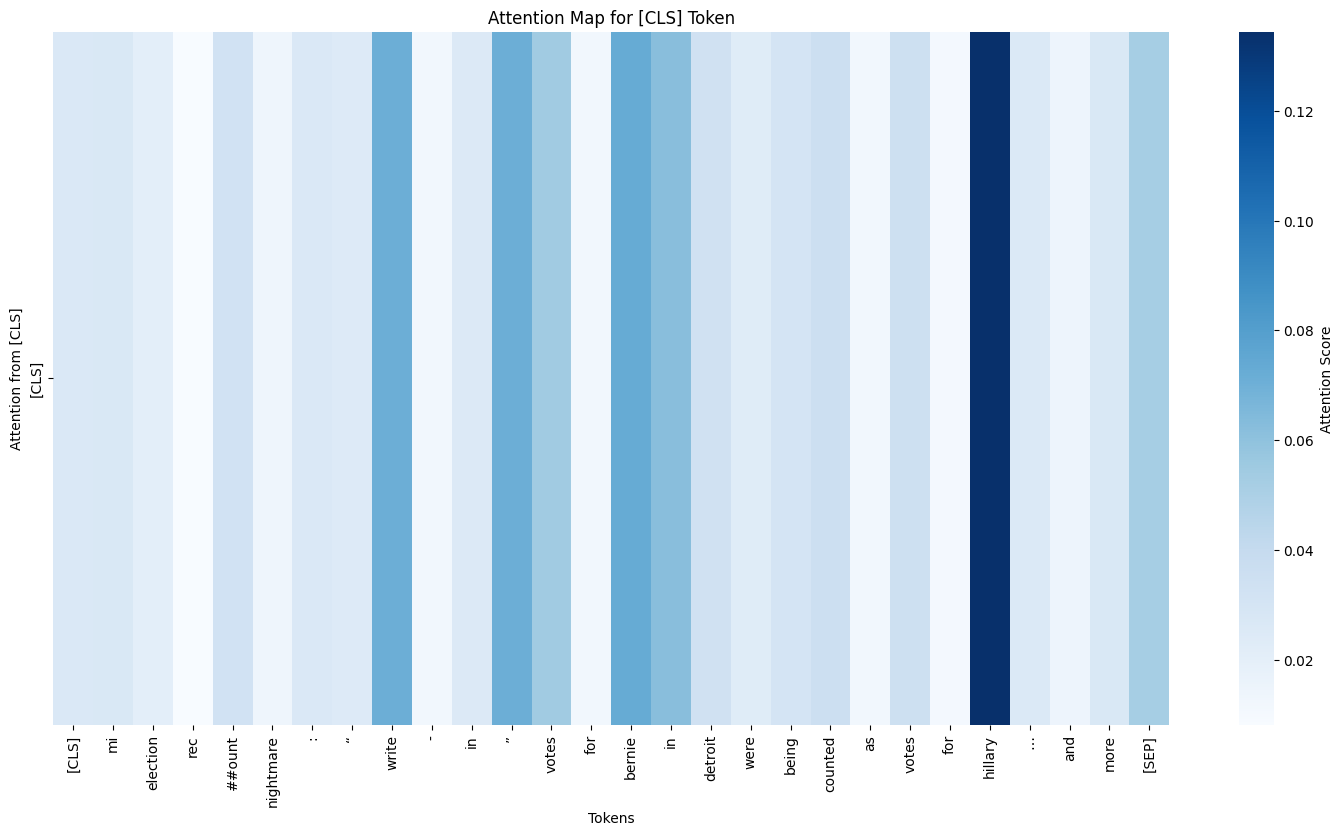

According to the dataset, this post inclucded or was fake news
Prediction: fake


In [49]:

index_explained_text = 4
text_to_explain = X_test[index_explained_text]
text_to_explain = text_to_explain[:1500] # limits possible long title to max length


model.config.output_attentions = True
model.config.output_hidden_states = True

model.eval()

input_for_visualization = tokenizer(text_to_explain, return_tensors="pt", truncation=True, padding=True).to(device)

with torch.no_grad():
    outputs = model(**input_for_visualization)

logits = outputs.logits
predicted_class_id = torch.argmax(logits, dim=1).item()



# Getting attention maps
attention = outputs.attentions  # List of layers with attention weights

attention_map = attention[-1][0][0]  # Last layer's attention for first head

# Visualizing attention to [CLS] token
cls_attention = attention_map[0].detach().cpu().numpy() #.cpu() necessary if ran on gpu


# Prepare tokens for labeling
tokens = tokenizer.convert_ids_to_tokens(input_for_visualization['input_ids'][0])


#Plots the attention map to visualize how much the model attends to the [CLS] token
plt.figure(figsize=(18, 9))
sns.heatmap(cls_attention.reshape(1, -1), cmap='Blues', cbar_kws={'label': 'Attention Score'}, xticklabels=tokens, yticklabels=["[CLS]"], cbar=True)
plt.title('Attention Map for [CLS] Token')
plt.xticks(rotation=90)
plt.xlabel('Tokens')
plt.ylabel('Attention from [CLS]')
plt.show()


if y_test[index_explained_text] == 0:
    print("according to the dataset, this post included or was real news")
else:
    print("According to the dataset, this post inclucded or was fake news")
print("Prediction:", "fake" if predicted_class_id == 1 else "real")

#Full attention + sorted attention scores map/matrix: (not used in report)

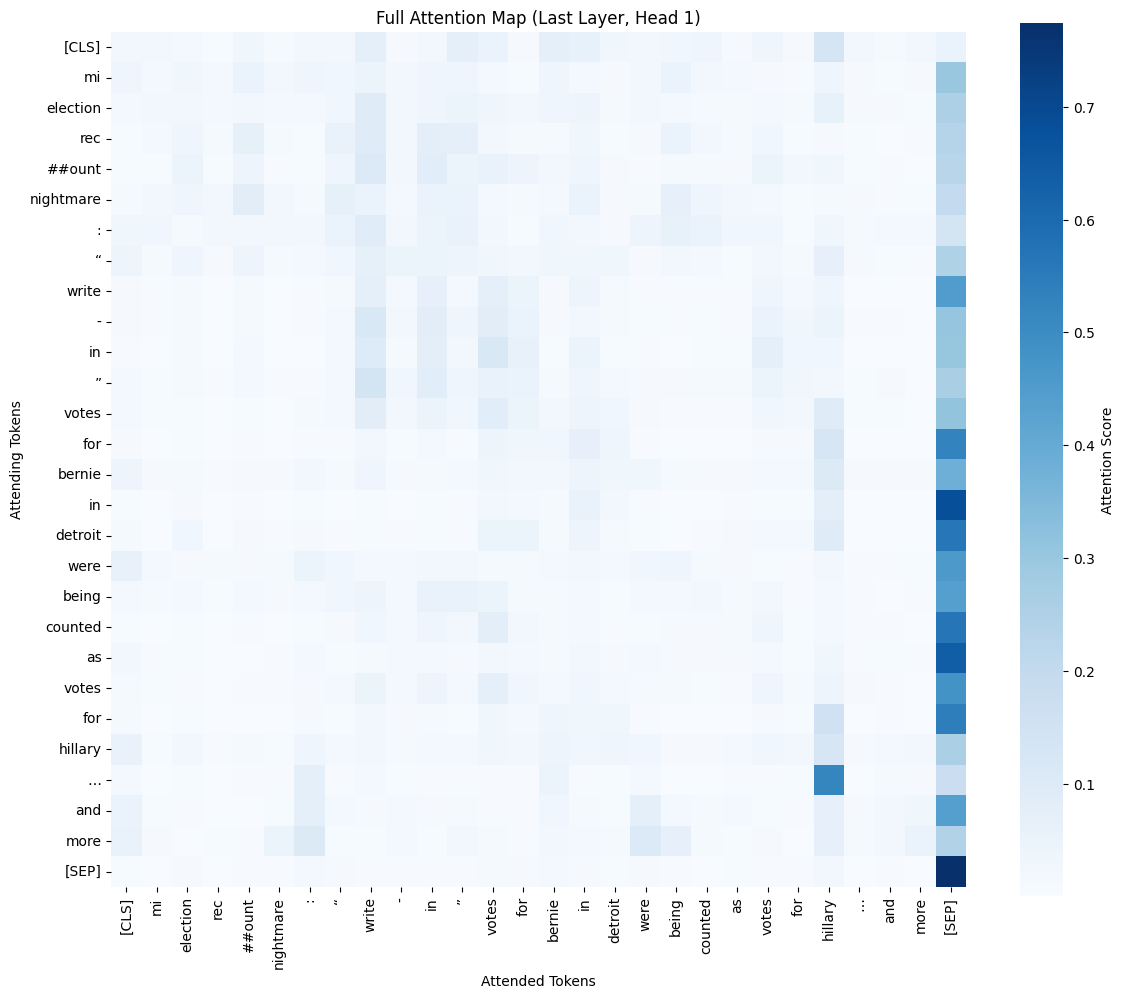

In [53]:
full_attention_matrix = attention[-1][0][0].detach().cpu().numpy()  # shape: [seq_len, seq_len]


# Plot full attention matrix
plt.figure(figsize=(12, 10))
sns.heatmap(full_attention_matrix, xticklabels=tokens, yticklabels=tokens, cmap='Blues', square=True, cbar_kws={"label": "Attention Score"})
plt.title("Full Attention Map (Last Layer, Head 1)")
plt.xlabel("Attended Tokens")
plt.ylabel("Attending Tokens")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [52]:
filtered_token_scores = []
attention_new = cls_attention.copy()

for i, token in enumerate(tokens):
  if token in string.punctuation: # punctuation marks are just biased and show up in every text
    continue
  filtered_token_scores.append((token, attention_new[i]))

sorted_tokens = sorted(filtered_token_scores, key=lambda x: x[1], reverse=True)

print(f"sorted attention scores from [CLS] token:\n")
print(f"{'Token':<15} {'Score'}")
print("-" * 25) # for structure to separate scores and variables
for token, score in sorted_tokens:
      print(f"{token:<15} {score:.4f}")

sorted attention scores from [CLS] token:

Token           Score
-------------------------
hillary         0.1343
bernie          0.0728
”               0.0710
write           0.0709
in              0.0620
votes           0.0543
[SEP]           0.0523
counted         0.0362
votes           0.0352
detroit         0.0336
##ount          0.0326
being           0.0308
mi              0.0272
more            0.0270
[CLS]           0.0269
…               0.0263
in              0.0257
“               0.0250
were            0.0232
election        0.0208
and             0.0147
nightmare       0.0141
as              0.0124
for             0.0123
for             0.0111
rec             0.0082
